In [1]:
# -*- coding: utf-8 -*-
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from keras.applications.vgg16 import VGG16
from keras.layers import Input, Activation, Dropout, Flatten, Dense
from keras.models import Sequential, Model
from keras import optimizers
from keras.utils import np_utils
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

Using TensorFlow backend.


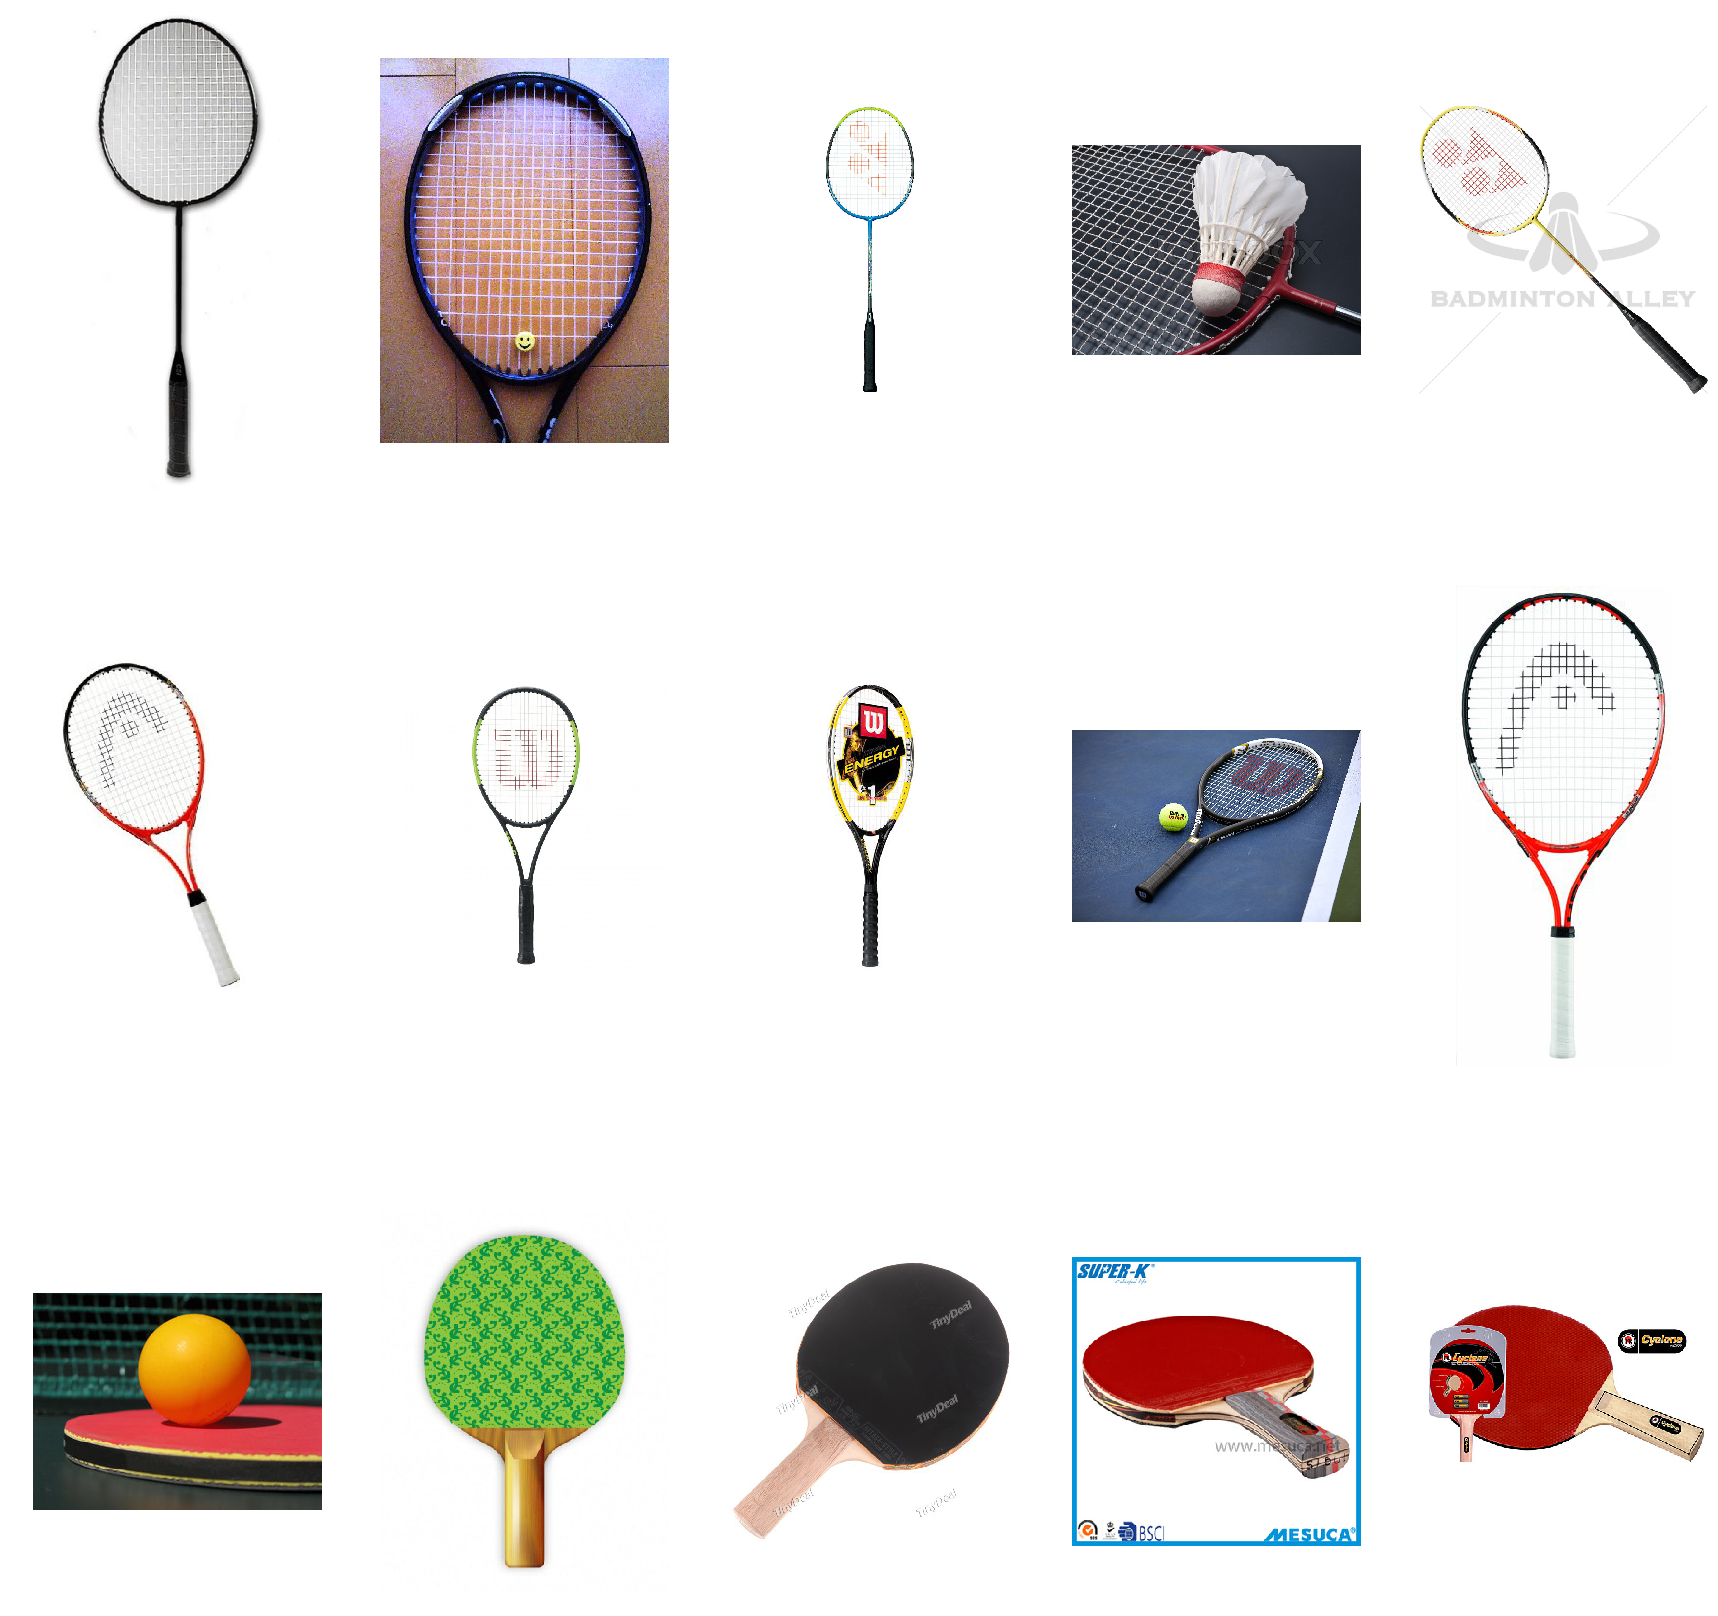

In [2]:
#どんな画像か確認
pos = 1
plt.figure(figsize=(30,30))
for dir in os.listdir("Crawling_data"):
    if dir != ".DS_Store": 
        dir1 = "Crawling_data/" + dir
        for file in os.listdir(dir1)[:5]:
            filepath = dir1 + "/" + file
            if file != ".DS_Store":
                try:
                    img = Image.open(filepath) 
                    plt.subplot(3, 5, pos)
                    plt.imshow(img)
                    plt.axis('off')
                    pos += 1
                except:
                    pass
    plt.savefig( 'plot_moto.png')



plt.show()

In [3]:
# 学習用のデータを作る.
image_list = []
label_list = []

# ./data/train 以下のorange,appleディレクトリ以下の画像を読み込む。


for dir in os.listdir("Crawling_data"):
    if dir != ".DS_Store":
        dir1 = "Crawling_data/" + dir
        label = 100

        if dir == "Tennis+Racket":    
            label = 0
        elif dir == "Badminton+racket":
            label = 1
        elif dir == "Ping+pong+paddle":
            label = 2
        elif dir == "Softtennis+Racket":
           label = 3
        elif dir == "Squash+Racket":
            label = 4
        

        for file in os.listdir(dir1):
            if file != ".DS_Store":
                try:
                    filepath = dir1 + "/" + file
                    # 画像を25x25pixelに変換し、1要素が[R,G,B]3要素を含む配列の25x25の２次元配列として読み込む。
                    # [R,G,B]はそれぞれが0-255の配列。
                    img = Image.open(filepath).resize((64, 64))
                    try:
                        r, g, b, a= img.split()  # RGBA形式がいるので
                    except:
                        r, g, b = img.split() 
                    img = Image.merge("RGB", (r, g, b))
                    image = np.array(img).astype('float32')
                    # 出来上がった配列をimage_listに追加。
                    image_list.append(image / 255.)
                    # 配列label_listに正解ラベルを追加
                    label_list.append(label)
                except:
                    pass
            
# kerasに渡すために変換。
image_list = np.array(image_list)
# クラスラベル（0-9）をone-hotエンコーディング形式に変換
Y = np_utils.to_categorical(label_list, 3)

/home/naoya/anaconda3/envs/opencv/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 262144 bytes but only got 0. Skipping tag 52
  " Skipping tag %s" % (size, len(data), tag))
/home/naoya/anaconda3/envs/opencv/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 15342764032 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/naoya/anaconda3/envs/opencv/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 285413634 bytes but only got 0. Skipping tag 780
  " Skipping tag %s" % (size, len(data), tag))
/home/naoya/anaconda3/envs/opencv/lib/python3.5/site-packages/PIL/TiffImagePlugin.py:692: UserWarning: Possibly corrupt EXIF data.  Expecting to read 525372 bytes but only got 9518. Skipping tag 55807
  " Skipping tag %s" % (size, len(data), tag))
/home/naoya/anacon

In [4]:
if len(image_list)==len(label_list):
    print(len(image_list))
    print(sum(Y))

2800
[ 890.  941.  969.]


In [5]:
# ランダムに画像をプロット
def plot_rackets5(X, y):
    plt.figure()

    # 画像を描画
    nclasses = 3
    pos = 1
    for targetClass in range(nclasses):
        targetIdx = []
        # クラスclassIDの画像のインデックスリストを取得
        for i in range(len(y)):
            if y[i] == targetClass:
                targetIdx.append(i)

        # 各クラスからランダムに選んだ最初の10個の画像を描画
        np.random.shuffle(targetIdx)
        for idx in targetIdx[:5]:
            img = Image.fromarray(np.uint8(X[idx] * 255))
            plt.subplot(3, 5, pos)
            plt.imshow(img)
            plt.axis('off')
            pos += 1

    plt.savefig( 'plot.png')



plot_rackets5(image_list,label_list)

<img src="plot.png">

In [6]:
print(image_list.shape,Y.shape)

(2800, 64, 64, 3) (2800, 3)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(image_list, Y, random_state=1, train_size=0.75)
X_train_cv, X_valid, y_train_cv, y_valid = train_test_split(X_train, y_train, random_state=1, train_size=0.75)    

/home/naoya/anaconda3/envs/opencv/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [8]:
# VGG16モデルと学習済み重みをロード
# Fully-connected層（FC）はいらないのでinclude_top=False）
input_tensor = Input(shape=X_train.shape[1:])
vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)

# FC層を構築
top_model = Sequential()
top_model.add(Flatten(input_shape=vgg16.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(3, activation='softmax'))

# VGG16とFCを接続
model = Model(input=vgg16.input, output=top_model(vgg16.output))

# 最後のconv層の直前までの層をfreeze
for layer in model.layers[:15]:
    layer.trainable = False

    
# Fine-tuningのときはSGDの方がよい
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

model.summary()
plot_model(model,to_file="vgg16.png")
file_path = ".model_weights.hdf5"

def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]

callbacks = get_callbacks(filepath=file_path, patience=3)

history = model.fit(X_train_cv, y_train_cv,
          batch_size=10,
          epochs=100,
          verbose=1,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

                             

/home/naoya/anaconda3/envs/opencv/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("se...)`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
__________

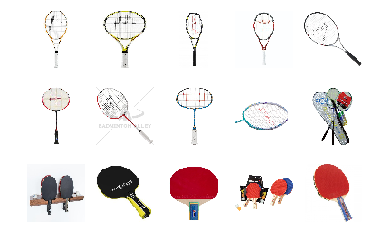

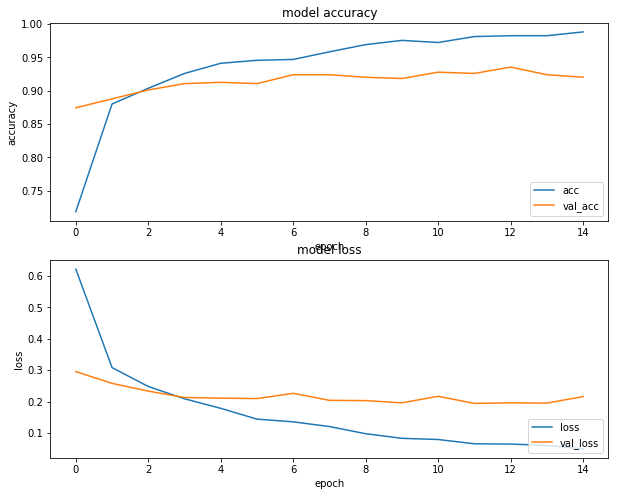

Test loss: 0.250956378111


In [9]:
# 学習履歴をプロット
def plot_history(history):
    plt.figure(figsize=(10,8))
    # print(history.history.keys())
    plt.subplot(2, 1, 1)
    # 精度の履歴をプロット
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['acc', 'val_acc'], loc='lower right')
    
    # 損失の履歴をプロット
    plt.subplot(2, 1, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['loss', 'val_loss'], loc='lower right')
    plt.show()

plot_history(history)

score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])